### visualize how pop responses change for choice/reward interactions

In [1]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd
import utils.behavioral_utils as behavioral_utils
import utils.information_utils as information_utils
import utils.visualization_utils as visualization_utils
import utils.pseudo_classifier_utils as pseudo_classifier_utils
import utils.classifier_utils as classifier_utils

import utils.io_utils as io_utils

import utils.glm_utils as glm_utils
from matplotlib import pyplot as plt
import matplotlib
import utils.spike_utils as spike_utils
import utils.subspace_utils as subspace_utils
from trial_splitters.condition_trial_splitter import ConditionTrialSplitter 
from utils.session_data import SessionData
from constants.behavioral_constants import *
from constants.decoding_constants import *
import seaborn as sns
from scripts.pseudo_decoding.belief_partitions.belief_partition_configs import *
import scripts.pseudo_decoding.belief_partitions.belief_partitions_io as belief_partitions_io

import scipy
import argparse
import copy

In [2]:
args = argparse.Namespace(
    **BeliefPartitionConfigs()._asdict()
)
args.beh_filters = {"Response": "Correct", "Choice": "Chose"}
args.shuffle_method = "session_permute"
args.subject = "both"
args.sig_unit_level = "pref_99th_window_filter_drift"
# args.region_level = "drive"
# args.regions = "Temporal"

order=["chose X / correct", "correct", "shuffle", "incorrect", "chose X / incorrect"]
conditions_maps = {
    "chose X / correct": {"Response": "Correct", "Choice": "Chose"},
    "chose X / incorrect": {"Response": "Incorrect", "Choice": "Chose"},

    "correct": {"Response": "Correct"},
    "incorrect": {"Response": "Incorrect"},

    # "not chose/correct": {"Response": "Correct", "Choice": "Not Chose"},
    # "not chose/incorrect": {"Response": "Incorrect", "Choice": "Not Chose"},
}

# order=["chose X / correct", "shuffle", "chose X / incorrect"]
# conditions_maps = {
#     "chose X / correct": {"Response": "Correct", "Choice": "Chose"},
#     "chose X / incorrect": {"Response": "Incorrect", "Choice": "Chose"},
#     # "not chose/correct": {"Response": "Correct", "Choice": "Not Chose"},
#     # "not chose/incorrect": {"Response": "Incorrect", "Choice": "Not Chose"},
# }

FileNotFoundError: [Errno 2] No such file or directory: '/data/patrick_res/update_projections/both_StimOnset_Response_Correct_pref_99th_window_filter_drift_units/CIRCLE_pref_projections.pickle'

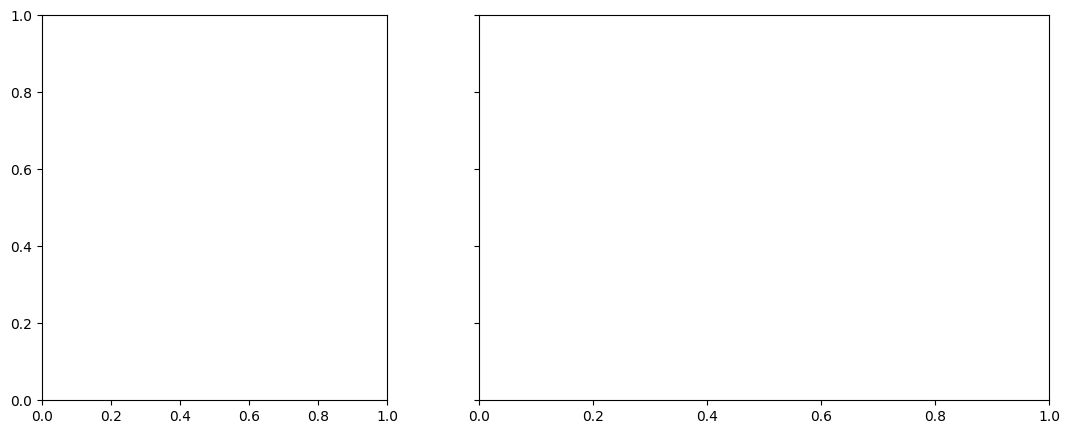

In [3]:
pref_args = copy.deepcopy(args)
pref_args.mode = "pref"

all_data = []
fig, axs = plt.subplots(1, 2, figsize=(13, 5), width_ratios=(20, 33), sharey=True)
for ax_idx, event in enumerate(["StimOnset", "FeedbackOnsetLong"]):
    all_conds = []
    for cond_name in conditions_maps:
        pref_args.trial_event = event
        pref_args.conditions = conditions_maps[cond_name]
        res = belief_partitions_io.read_update_projections(pref_args)
        res["cond"] = res.apply(lambda x: "shuffle" if "shuffle" in x["mode"] else cond_name, axis=1)
        all_conds.append(res)
    all_conds = pd.concat(all_conds)
    all_conds["trial_event"] = event
    all_conds["Time"] = all_conds["TimeIdx"] / 10 + 0.1
    all_data.append(all_conds)
    sns.lineplot(all_conds, x="Time", y="proj", hue="cond", ax=axs[ax_idx], hue_order=order)
    axs[ax_idx].set_xlabel(f"Time to {event}")
axs[0].set_ylabel("Change in projection along preference of X")

visualization_utils.format_plot(axs)

all_data = pd.concat(all_data)

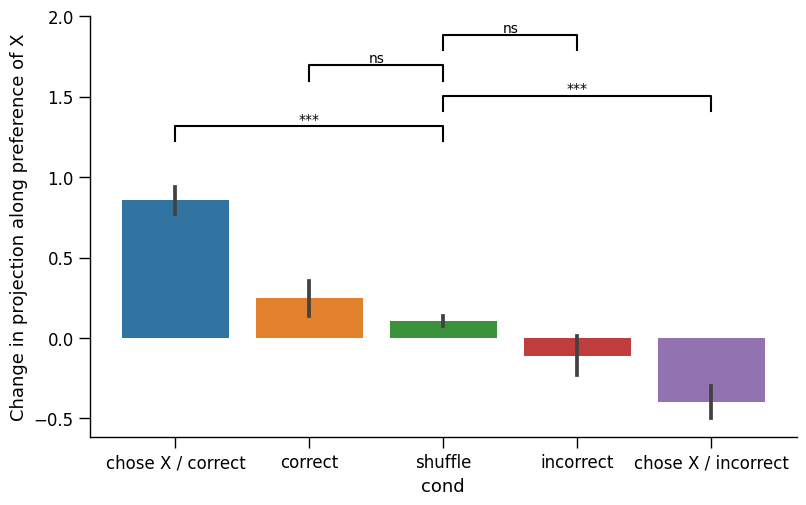

In [4]:
cross_fix = all_data[(all_data.trial_event == "StimOnset") & (all_data.TimeIdx < 0)]
# order=["not chose/correct", "shuffle", "not chose/incorrect"]
cross_fix = cross_fix.sort_values(by="cond", key=lambda x: x.map(order.index))

fig, ax = plt.subplots(figsize=(8, 5))
sns.barplot(cross_fix, x="cond", y="proj", errorbar="se", ax=ax)
visualization_utils.add_significance_bars(fig, ax, cross_fix, "cond", "proj", pairs=[
    ("chose X / correct", "shuffle"),
    ("chose X / incorrect", "shuffle"),
    ("correct", "shuffle"),
    ("incorrect", "shuffle"),
    # ("not chose/correct", "shuffle"),
    # ("not chose/incorrect", "shuffle"),
])
ax.set_ylabel("Change in projection along preference of X")

visualization_utils.format_plot(ax)



### What about for confidence:

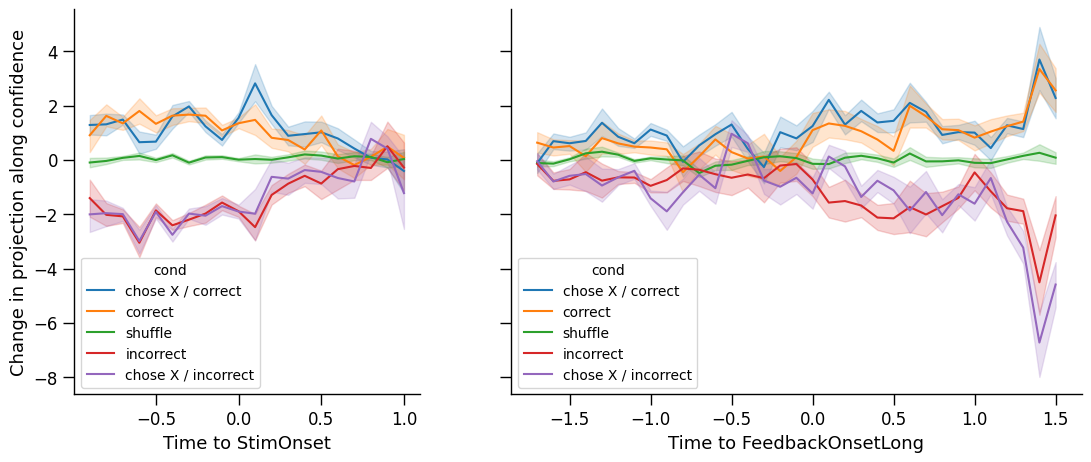

In [5]:
conf_args = copy.deepcopy(args)
conf_args.mode = "conf"

all_data = []
fig, axs = plt.subplots(1, 2, figsize=(13, 5), width_ratios=(20, 33), sharey=True)
for ax_idx, event in enumerate(["StimOnset", "FeedbackOnsetLong"]):
    all_conds = []
    for cond_name in conditions_maps:
        conf_args.trial_event = event
        conf_args.conditions = conditions_maps[cond_name]
        res = belief_partitions_io.read_update_projections(conf_args)
        res["cond"] = res.apply(lambda x: "shuffle" if "shuffle" in x["mode"] else cond_name, axis=1)
        all_conds.append(res)
    all_conds = pd.concat(all_conds)
    all_conds["trial_event"] = event
    all_conds["Time"] = all_conds["TimeIdx"] / 10 + 0.1

    all_data.append(all_conds)
    sns.lineplot(all_conds, x="Time", y="proj", hue="cond", hue_order=order, ax=axs[ax_idx])
    axs[ax_idx].set_xlabel(f"Time to {event}")
axs[0].set_ylabel("Change in projection along confidence")

visualization_utils.format_plot(axs)
all_data = pd.concat(all_data)

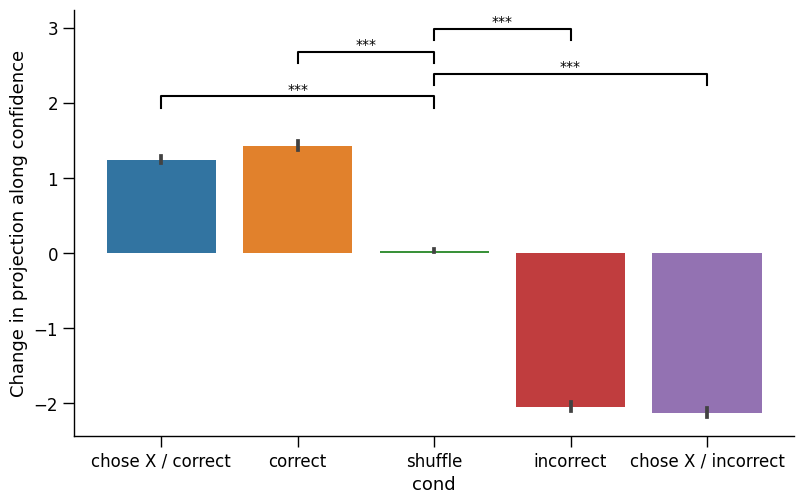

In [6]:
cross_fix = all_data[(all_data.trial_event == "StimOnset") & (all_data.TimeIdx < 0)]
cross_fix = cross_fix.sort_values(by="cond", key=lambda x: x.map(order.index))

fig, ax = plt.subplots(figsize=(8, 5))
sns.barplot(cross_fix, x="cond", y="proj", errorbar="se", ax=ax)
visualization_utils.add_significance_bars(fig, ax, cross_fix, "cond", "proj", pairs=[
    ("chose X / correct", "shuffle"),
    ("chose X / incorrect", "shuffle"),
    ("correct", "shuffle"),
    ("incorrect", "shuffle"),
])
ax.set_ylabel("Change in projection along confidence")
visualization_utils.format_plot(ax)
